# Sales and traffic exercise 

**SUMMARY**
The data are explored for visual patterns and trends that might complicate the modeling results. There is an obvious daily and weekly pattern that introduces a high-frequency seasonality and on an annual basis a pick-up of sales and traffic between the Thanksgiving to New Year period. The data have a significant number of '0' values that represent closed periods of the shop. Dealing with these is tough and I have no good work-around but they clearly impact the model and provide a very poor model once seasonality has been adjusted. Some form of smoothing is required or use of a discrete model rather than a continuous time series model. Here I have modeled the data using SARIMAX and evaluated using the residuals and testing the model on previous data within the sales time period. The model is so inaccurate and needs significant tuning o I haven't provided a forecast - until the zero values are dealt with the model has very wide confidence intervals that make the result meaningless.

In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from datetime import datetime
import datetime as dt

#Mute warning messages: If errors occur, hash-out this import
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

## Considerations and model rationale

The training exercise consists of 2 dataframes that are time-series. The first contains sales figures per hour in cents for a shop in the USA and the second dataframe contains traffic that represents people measured by sensors. There are missing data and the time series capture multiple holidays and other events. The aim is to predict the sales and traffic per hour for the next month. The type of shop is unknown. 

### Considerations

**Holidays**:- The USA has 10 Federal holidays that are observed by Federal government although in practice only 7 are usually observed in business and commerce. These are January 1st (New Year), Memorial Day (late May), Independence Day (July 4th), Labor Day (beginning September), Thanksgiving (third Thursday in November) and the next immediate Friday (not an official holiday), and finally Christmas Day in late December. In recent years, the USA has followed a trend similar to Europe in that the Christmas-New Year period has turned into a more protracted holiday period although technically the USA on observes Christmas Day. 

*Expectation* - depending on the type of store, you could expect an increase or decrease in traffic and sales during holiday periods. Holidays with an anticipated decrease in sales (Thanksgiving day itself, Christmas day) will have an increase in sales both before and after. They have complex lags and preceding events. They could look like 'humps' in the data with a dip on the holiday itself..


**Major sales**:- The USA also has Black Friday that falls just before Thanksgiving and is a time of massive sales across lots of different sectors in the same manner as New Year sales in the UK. Cyber Monday has also appeared in recent years although whether that impacts the shop in this training exercise is unknown.

*Expectations* - There could be a big increase in November in sales and also late December/early January. 

**Missing data**:- Missing values (0) could represent multiple causes that may or may not be primary to the data under review. They could represent no sales within the hour time period, they might represent a temporary closed period (if traffic is also 0), they could be a lag within the first one hour between people entering the shop just before the second hour time period within a trading day, or they could mean no data were recorded. Data exploration is needed to see any pattern that might help. Traffic values that score 0 could also have several underlying causes: They could be faulty sensors, sensors that broke-down for a period of time, sensors weren't installed for part of the time series, there is a lag between traffic and sales so a sale could occur in a time period without traffic (especially if it's at the end of a trading day), or no data were recorded. Faulty sensors might be indicated by random 0 entries throughout th time series, and broken or missing sensors might be represented by an extended series of time points that have 0 entries. If there is no traffic but a sale is recorded it could also indicate that the shop sales products outside of the store - for example online, by telephone or on a forecourt like a gas station.None of these examples would score as 'traffic' but would score as a sale. 

Ideally a continuous time series is needed so missing time periods need attention. When the shop is closed, these will score as '0' sales and traffic so there will be an artificial seasonality to the data -   the dataset will have several hours of data and then many hours of zeros. 

### Model rationale
Since these data represent a time series, OLS linear regression is not suitable since there will be a time component that introduces lag and is correlated with both the inputs and outputs. The issue of multicollinearity would come into play and if the two time series have different distributions or seasonalities that would deliver erroneous results. I'm expecting seasonality on a daily basis because I'm not excluding or smoothing the zero values. I've yet to find a good work-around for this issue since the expected output is hours not larger time domains (e.g. weeks) where data can be smoothed.  Since the exercise implies one model, the approach will be to use SARIMAX and to evaluate its performance in terms of normality of the residuals from the model.  

## Data exploration

In [5]:
''' 
Load dataframes and inspect shape
'''

sales = pd.read_csv('training_Sales.csv')
traffic = pd.read_csv('training_Traffic.csv')

print(sales.describe())
print('\n',traffic.describe())

              Value
count  67058.000000
mean     815.701631
std      100.306658
min        0.000000
25%      754.000000
50%      793.000000
75%      851.000000
max     6435.000000

               Value
count  58437.000000
mean       4.208755
std        4.059862
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       39.000000


In [9]:
## They have different shapes: How many missing (0) values are in the dataframes:
print('Sales with 0 "Value" scores = ', (sales.Value == 0).sum())
print('Traffic with 0 "Value" scores = ', (traffic.Value == 0).sum())

## when does the time series start?
print('\n Sales df start: \n',sales.head())
print('\n Traffic df start: \n',traffic.head())

## When does the time series end?
print('\n Sales df finish: \n',sales.tail(1))
print('\n Traffic df finish: \n',traffic.tail(1))

Sales with 0 "Value" scores =  1
Traffic with 0 "Value" scores =  6169

 Sales df start: 
                   Date  Value
0  2013-11-07 13:00:00    830
1  2013-11-07 13:15:00    885
2  2013-11-07 13:30:00    938
3  2013-11-07 13:45:00    804
4  2013-11-07 14:00:00    793

 Traffic df start: 
                   Date  Value
0  2015-01-01 10:00:00      0
1  2015-01-01 10:15:00      1
2  2015-01-01 10:30:00      4
3  2015-01-01 10:45:00      3
4  2015-01-01 11:00:00      1

 Sales df finish: 
                       Date  Value
67057  2018-05-06 19:00:00    759

 Traffic df finish: 
                       Date  Value
58436  2018-05-06 21:00:00      1


In [11]:
## Are the 0 values random for traffic or in a series of their own?
traffic.sort_values(by = ['Value'])[:10]

,Date,Value
0,2015-01-01 10:00:00,0
40566,2017-05-01 10:30:00,0
22810,2016-04-23 21:15:00,0
22809,2016-04-23 21:00:00,0
22766,2016-04-23 10:15:00,0
22765,2016-04-23 10:00:00,0
22764,2016-04-23 09:45:00,0
5232,2015-04-23 09:30:00,0
5231,2015-04-23 08:45:00,0
5230,2015-04-23 08:00:00,0


* The size of the dataframes is different and the sales figures have a longer time series. Sales start in 2013 while traffic has values from 2015.
* There are sales figures when there are no traffic figures. There must be a lag and/or different ways of registering a sale
* Time periods are in 15 minute increments.

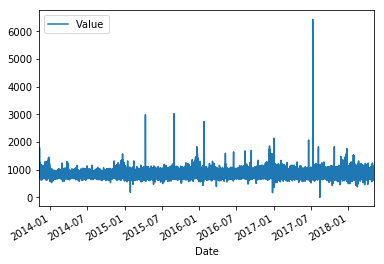

'\nNo obvious patterns here but a few outliers that need exploring. \nScale makes it difficult to see the patterns and twhether there is any obvious seasonality or cyclicity\n'

In [16]:
## Plot the sales figures.
sales.index = pd.to_datetime(sales.Date) #These are date-time object
sales.plot()
plt.show()

'''
No obvious patterns here but a few outliers that need exploring. 
Scale makes it difficult to see the patterns and twhether there is any obvious seasonality or cyclicity
'''

In [17]:
## When are the outlier periods recorded?
sales.sort_values(by = ['Value'], ascending=False)[:15]

# '''
# The scale doesn't help, but it looks like there are peak sales that might be connected with 
# Independence Day celebrations (or just after) and also the Labor Day holidays. The fourth highest sales
# figure may relate to Martin Luther King Day.  There is no obvious pattern although December seems to 
# have generally higher sales figures.
# '''

,Date,Value
Date,,
2017-07-09 19:15:00,2017-07-09 19:15:00,6435
2015-08-29 14:00:00,2015-08-29 14:00:00,3027
2015-04-11 14:15:00,2015-04-11 14:15:00,2987
2016-01-23 14:15:00,2016-01-23 14:15:00,2740
2016-12-31 17:00:00,2016-12-31 17:00:00,2144
2017-06-19 15:30:00,2017-06-19 15:30:00,2075
2017-06-19 15:45:00,2017-06-19 15:45:00,1950
2016-12-09 22:45:00,2016-12-09 22:45:00,1860
2015-12-19 13:00:00,2015-12-19 13:00:00,1832


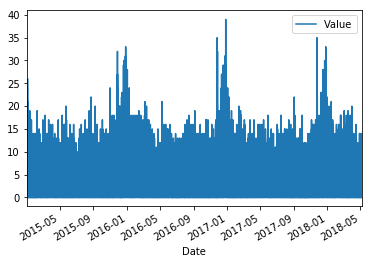

'\nThe traffic figures appear to have some cyclicity based on visual inspection.\n'

In [15]:
traffic.index = pd.to_datetime(traffic.Date)
traffic.plot()
plt.show()

'''
The traffic figures appear to have some cyclicity based on visual inspection.
''' 

### Convert to hours and merge

In [18]:
'''
Convert to sales df to hours. pd.Grouper only works if you convert the datetime as 0er the previous steps.
'''
sales_hr = sales.groupby(pd.Grouper(freq='H')).sum()
traffic_hr = traffic.groupby(pd.Grouper(freq='H')).sum()

In [19]:
## Do a larger view so you can see how many hours the shop is open (e.g. 40). It's from 8am to 8pm
sales_hr.head() 
# traffic_hr.head()

,Value
Date,
2013-11-07 13:00:00,3457
2013-11-07 14:00:00,2250
2013-11-07 15:00:00,0
2013-11-07 16:00:00,729
2013-11-07 17:00:00,0


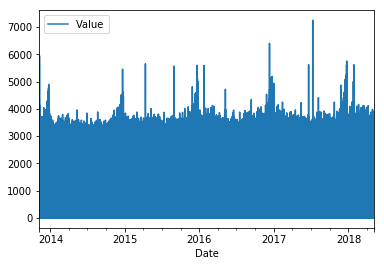

In [20]:
sales_hr.plot()
plt.show()

In [21]:
'''
Merge sales and traffic. 
'''
sales_traffic_hr = pd.merge(sales_hr, traffic_hr, on='Date')

## Check the columns
sales_traffic_hr.columns

## Rename the columns
sales_traffic_hr = sales_traffic_hr.rename(columns={'Value_x': 'Sales', 'Value_y': 'Traffic'})

In [22]:
sales_traffic_hr.tail()
# sales_traffic_hr.shape

,Sales,Traffic
Date,,
2018-05-06 15:00:00,3645,41
2018-05-06 16:00:00,3372,33
2018-05-06 17:00:00,3077,27
2018-05-06 18:00:00,3190,14
2018-05-06 19:00:00,759,4


Some take home points:-

**Outliers** 
Should these be removed? They may be correlated with lower sales later in the same month assuming that loyal customers are making these purchases. Will the really screw-up the model?

**Different time series durations**
This is a problem if both traffic and sales are part of the same model. They need to match. So cut the df so that only matching hour data are present. This cuts out c. 2 years of sales data. In addition this is a large amount of data so for expediency the dataframe may need to be cut to a smaller time window just to run on my computer. 

There are lots of zeros in the dataset - when the data are grouped into hours, it's obvious that many of these are when the shop is shut (after 8pm, before 8am). Question - should these be culled? Or since the same values will be present in the forecast month ahead, then they form part of the pattern and should stay? Not sure...so keep them in to start with, and then remove all rows with sales == 0 and traffic == 0. A continuous series is needed so I'm keeping them for parsimony here until I can figure a suitable alternative! (Needs more personal researching)


## Model

Before fitting ARIMA type models, the data need to be stationary and needs exploring. There are different ways to get a stationary series - fit many models iteratively and then select the one with the lowest log-likelihood (GridSearch) or use an autocorrelation and partial autocorrelation plot and then check with a Dickey Fuller test.

**Note** There is a lot of data here that takes too long to run on my laptop and chokes the system so I'm cutting the df to the last 18 month.

In [23]:
cut_df = sales_traffic_hr.loc['2016-11-01 01:00:00':'2018-05-06 19:00:00']
cut_df.shape

(13243, 2)

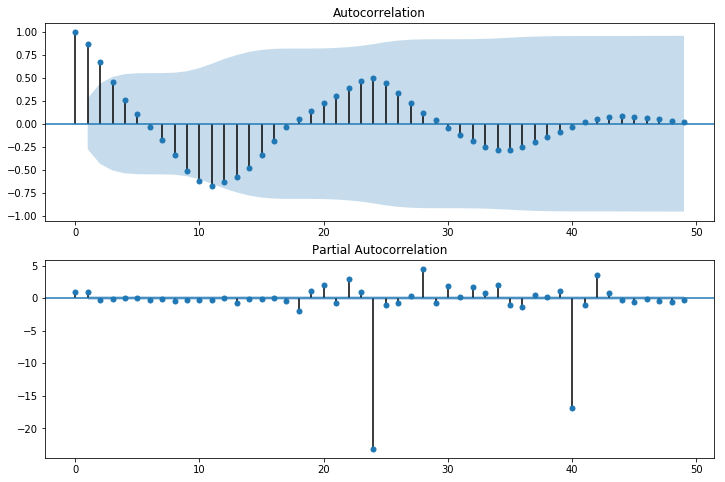

In [24]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(cut_df['Sales'][:50], ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(cut_df['Sales'] [:50], ax=ax2)
plt.show()


# #OK so this implies seasonality - daily patterns as expected. Limit to first 50.

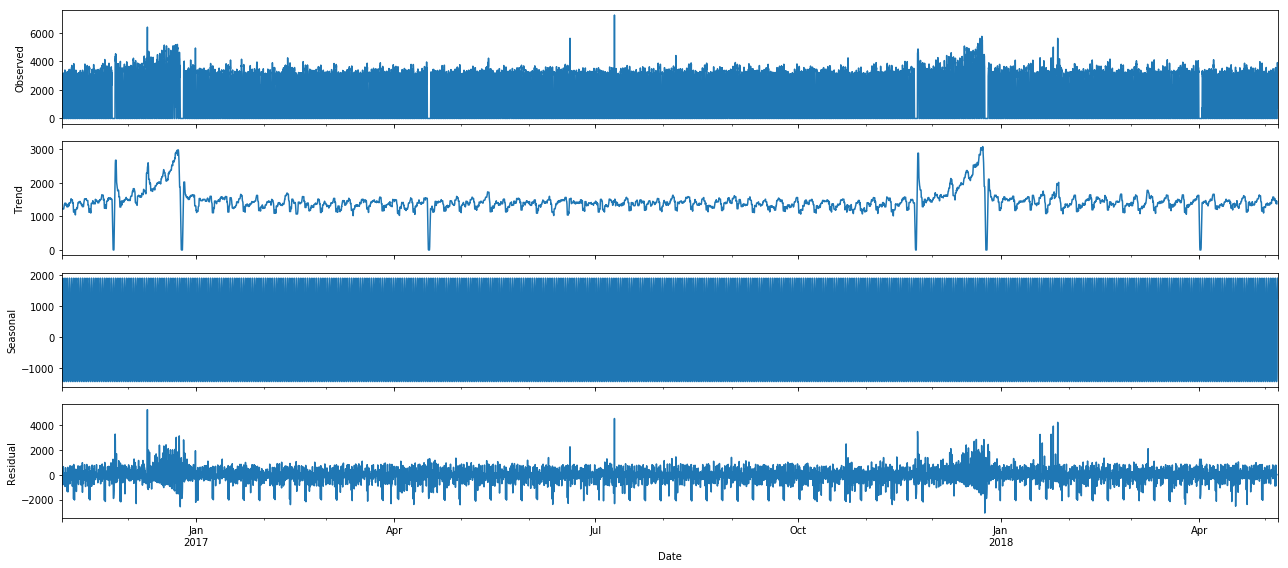

In [26]:
'''
Check time-series with decomposition that splits input into trend, seasonality and noise components
'''
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(cut_df.Sales, model='additive')
fig = decomposition.plot()
plt.show()

## The major trend here seems to be at the end of the year from Thanksgiving to New Year where there is
## a pick-up in sales. Seasonality appears to be daily (at night from 8pm-8a there are no sales). 
## The residuals appear to show daily trends.


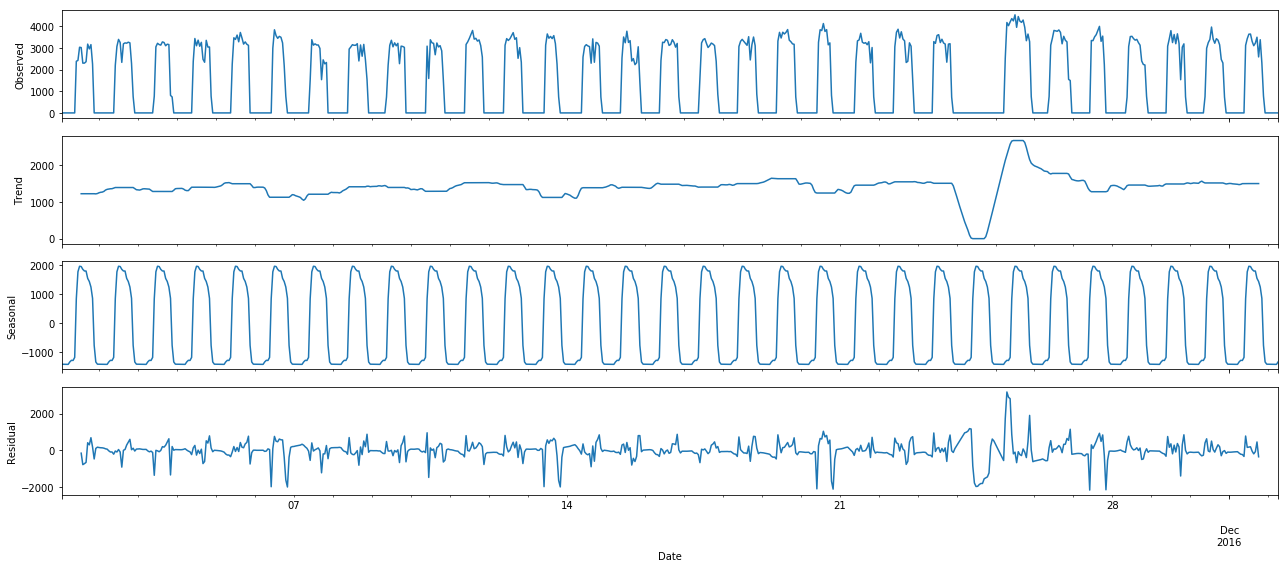

In [27]:
decomposition = sm.tsa.seasonal_decompose(cut_df.Sales[:750], model='additive') #750 approximates the hours in November
fig = decomposition.plot()
plt.show()

#Shows Thanksgiving as indicated by the gap.

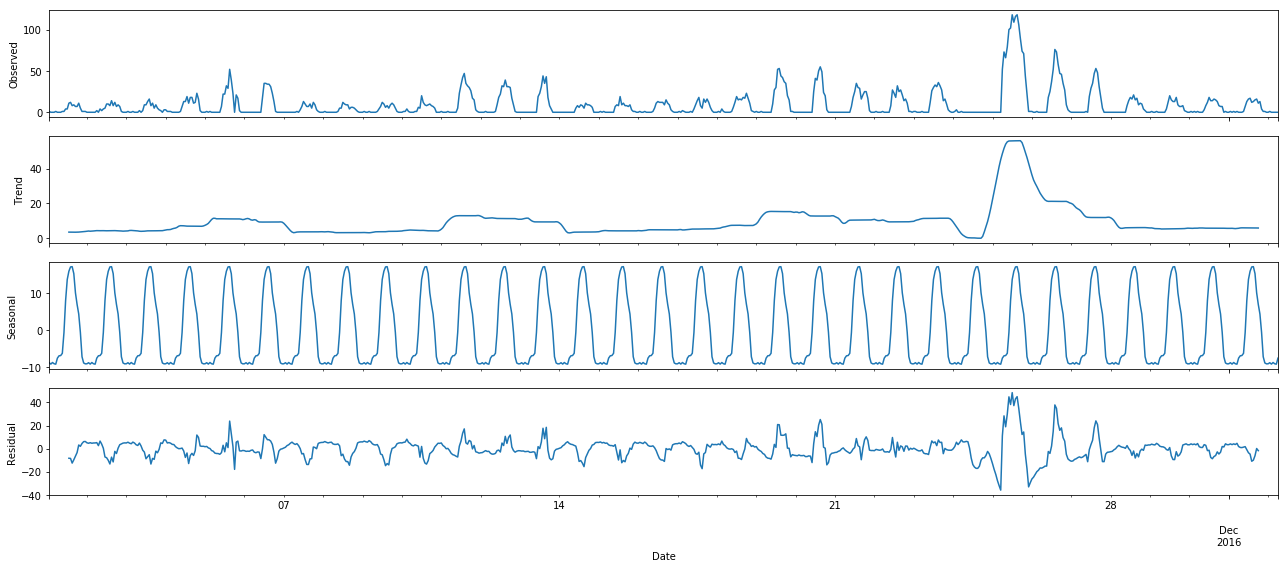

In [28]:
## Show decomposition for traffic

decomposition = sm.tsa.seasonal_decompose(cut_df.Traffic[:750], model='additive') #750 approximates the hours in Novemeber
fig = decomposition.plot()
plt.show()

There is a seasonal trend in the days and in the weeks implying greater sales towards the end of a week. This is match by traffic with is intuitive.

In [33]:
# Dickey Fuller test for stationarity:

sm.tsa.stattools.adfuller(cut_df.Sales)

## The strong negative value and the very small p value mean the null hypothesis is rejected since it is smaller 
## than the critical values - it does not have a unit root and implies a stationary time-series although the diagram 
## of PCF and ACF plus the decomposition imply differently. Presumably the data have a cyclostationary pattern??  

(-13.780512241615735,
 9.315372842142262e-26,
 41,
 13201,
 {'1%': -3.430845460345894,
  '5%': -2.8617589698479695,
  '10%': -2.5668865527450127},
 203400.96479161966)

In [ ]:
##This will run  a SARIMAX GridSearch but takes a very very long time. 

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[1], x[1], x[2], 24) for x in
list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(cut_df['Sales'], order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal,
                                                 results.aic))
        except:continue


In [40]:
## For parsimony I'm estimating the model parameters. These will need tuning

model = sm.tsa.statespace.SARIMAX(cut_df['Sales'],order=(2, 1, 2), seasonal_order=(1, 1, 0,12), 
                                enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                13243
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 12)   Log Likelihood             -107547.059
Date:                            Tue, 16 Apr 2019   AIC                         215106.118
Time:                                    10:05:51   BIC                         215151.053
Sample:                                11-01-2016   HQIC                        215121.120
                                     - 05-06-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9854      0.140      7.019      0.000       0.710       1.261
ar.L2         -0.1526      0.080   

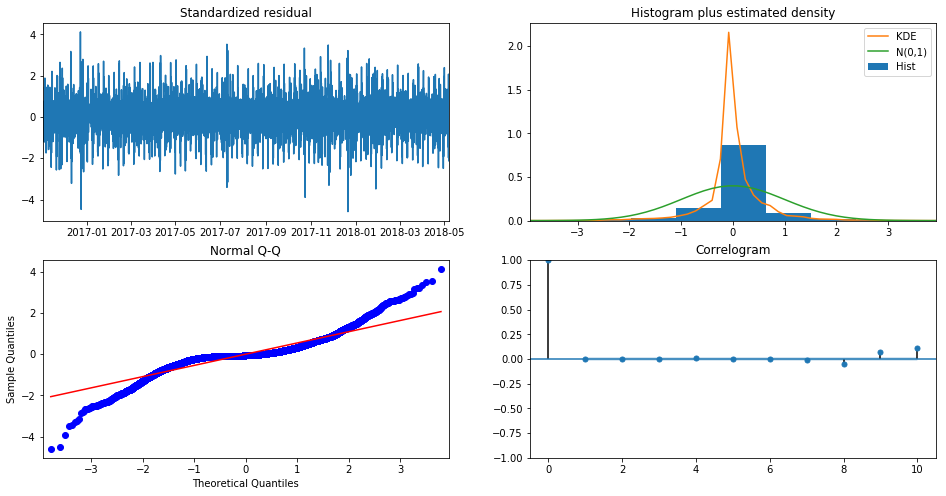

In [41]:
## Run diagnostics to see how the model behaves
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## The plot doesn't look good - the QQ plot shows that this still diverts from normality. 
## Different paramters are needed. Seasonality hasn't been effectively removed.

## Validating model

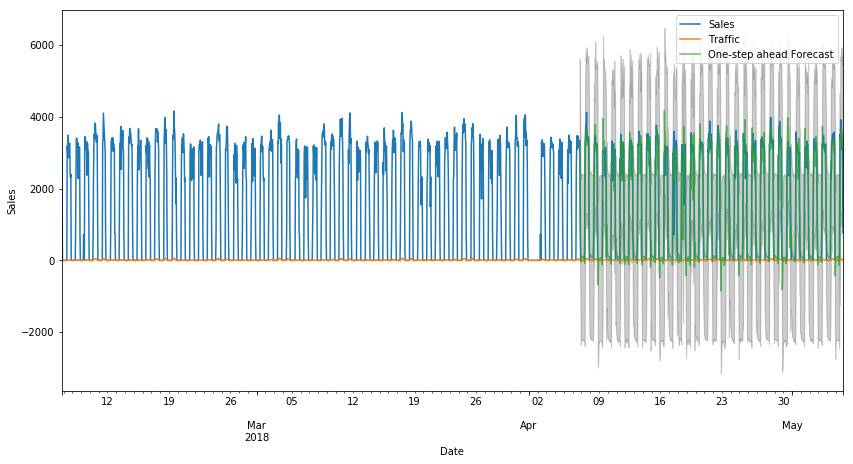

In [42]:
##Forecast the model by predicting the final month of the time series for which there is data:

prediction = results.get_prediction(start=pd.to_datetime('2018-04-06 19:00:00'), dynamic=False)
pred_ci = prediction.conf_int()

ax = cut_df['2018-02-06 19:00:00':].plot(label='observed')
prediction.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

##OK this is a really poor model!

In [44]:
##Integrating the traffic information
#Check causality between traffic and sales - this should be a given! 
#The order matters. The time averging into hours may make traffic-sales appear contemporaneous.

print(sm.tsa.stattools.grangercausalitytests(cut_df[['Traffic', 'Sales']],1))
print('\n\n',sm.tsa.stattools.grangercausalitytests(cut_df[['Sales','Traffic']],1))


'''
Suggests time averging can't distinguish causality since we can reject the null for both cases..
'''


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=73.0313 , p=0.0000  , df_denom=13239, df_num=1
ssr based chi2 test:   chi2=73.0479 , p=0.0000  , df=1
likelihood ratio test: chi2=72.8471 , p=0.0000  , df=1
parameter F test:         F=73.0313 , p=0.0000  , df_denom=13239, df_num=1
{1: ({'ssr_ftest': (73.03131561870477, 1.4146499509048993e-17, 13239.0, 1), 'ssr_chi2test': (73.04786474982163, 1.2654342941935038e-17, 1), 'lrtest': (72.84712287476577, 1.400916801219889e-17, 1), 'params_ftest': (73.03131561869955, 1.4146499509080353e-17, 13239.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000207032B0438>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000207032B0550>, array([[0., 1., 0.]])])}

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=196.3332, p=0.0000  , df_denom=13239, df_num=1
ssr based chi2 test:   chi2=196.3777, p=0.0000  , df=1
likelihood ratio test: chi2=194.9

In [45]:
'''
Put both traffic and sales into the same model. Need to introduce a lag component as an exogenous variable.
'''

cut_df['diffT'] = cut_df['Sales']
cut_df['lag'] = cut_df['diffT'].shift()
cut_df.dropna(inplace=True)

model = sm.tsa.SARIMAX(endog=cut_df['Sales'], exog=cut_df[['lag']],order=(2, 1, 2), seasonal_order=(1, 1, 0,12), 
                                enforce_stationarity=False, enforce_invertibility=False)

results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                13242
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 12)   Log Likelihood             -107555.267
Date:                            Tue, 16 Apr 2019   AIC                         215124.535
Time:                                    10:21:52   BIC                         215176.958
Sample:                                11-01-2016   HQIC                        215142.037
                                     - 05-06-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lag           -0.1260      6.739     -0.019      0.985     -13.333      13.081
ar.L1          0.5507      9.063   

In [49]:
'''
Forecasting one month ahead:
The model is really poor so this will produce a meaningless result
'''

#forecast, std,conf = results.forecast(steps=744, exog=cut_df[['lag']) #Approx hours in the next month. Needs an exog elemnt of len=744
#plt.plot(forecast)

'\nForecasting one month ahead:\nThe model is really poor so this will produce a meaningless result\n'

References:

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

https://barnesanalytics.com/analyzing-multivariate-time-series-using-arimax-in-python-with-statsmodels
    